In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/root/anaconda3/envs/finance/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
class IndexMaker:
    """How to make indices manually"""
    """If one want to use module, possible to use TA-Lib for example"""
    """https://mrjbq7.github.io/ta-lib/"""
    
    def __init__(self, sample):
        self.sample = sample.copy()
    
    def ohlc(self):
        ohlc = self.sample[['Open', 'High', 'Low', 'Close']]
        ohlc['number'] = ohlc.index.map(mdates.date2num)
        return ohlc[['number', 'Open', 'High', 'Low', 'Close']]
    
    def moving_avg(self, days):
        ma = self.sample[['Close']].copy()
        ma['MA'+str(days)] = ma.Close.rolling(window=days).mean()
        ma['number'] = ma.index.map(mdates.date2num)
        return ma[['number', 'MA'+str(days)]]
    
    def exp_moving_avg(self, days):
        ema = self.sample[['Close']].copy()
        ema['EMA'+str(days)] = ema.Close.ewm(span=days).mean()
        ema['number'] = ema.index.map(mdates.date2num)
        return ema[['number', 'EMA'+str(days)]]
    
    def bollinger_band(self, days=20):
        bb = self.sample[['Close']].copy()
        bb['Center'] = bb.Close.rolling(window=days).mean()
        bb['Upper'] = bb.Center + 2.*bb.Close.rolling(window=days).std()
        bb['Lower'] = bb.Center - 2.*bb.Close.rolling(window=days).std()
        bb['PercentB'] = (bb.Close - bb.Lower)/(bb.Upper - bb.Lower)
        bb['number'] = bb.index.map(mdates.date2num)
        return bb[['number', 'Center', 'Upper', 'Lower', 'PercentB']]
    
    def RSI(self, days):
        rsi = self.sample[['Close']].copy()
        rsi['U'] = 0.
        rsi['D'] = 0.
        for date in rsi.index:
            if rsi.loc[date, 'Close'] > rsi.shift(1).loc[date, 'Close']:
                rsi.loc[date, 'U'] = rsi.loc[date, 'Close'] - rsi.shift(1).loc[date, 'Close']
                rsi.loc[date, 'D'] = 0.
            else:
                rsi.loc[date, 'D'] = rsi.shift(1).loc[date, 'Close'] - rsi.loc[date, 'Close']
                rsi.loc[date, 'U'] = 0.
        rsi['AU'] = rsi['U'].rolling(window=days).mean()
        rsi['AD'] = rsi['D'].rolling(window=days).mean()
        rsi['RSI'] = rsi['AU']/(rsi['AU']+rsi['AD'])
        rsi['number'] = rsi.index.map(mdates.date2num)
        return rsi[['number', 'AU', 'AD', 'RSI']]

    def MFI(self, days):
        mfi = self.sample[['High', 'Low', 'Close', 'Volume']].copy()
        mfi['TP'] = (mfi['High'] + mfi['Low'] + mfi['Close'])/3
        mfi['PMF'] = 0.
        mfi['NMF'] = 0.
        for date in mfi.index:
            if mfi.loc[date, 'TP'] > mfi.shift(1).loc[date, 'TP']:
                mfi.loc[date, 'PMF'] = mfi.loc[date, 'TP']*mfi.loc[date, 'Volume']
                mfi.loc[date, 'NMF'] = 0.
            else:
                mfi.loc[date, 'NMF'] = mfi.loc[date, 'TP']*mfi.loc[date, 'Volume']
                mfi.loc[date, 'PMF'] = 0.
        mfi['MFI'] = mfi.PMF.rolling(window=days).sum()/(mfi.PMF.rolling(window=days).sum()+mfi.NMF.rolling(window=days).sum())
        mfi['number'] = mfi.index.map(mdates.date2num)
        return mfi[['number', 'TP', 'PMF', 'NMF', 'MFI']]

    def momentum(self, days=12):
        momentum = self.sample[['Close']].copy()
        momentum['Momentum'] = (momentum['Close'] - momentum.shift(days)['Close'])/momentum.shift(12)['Close']
        momentum['number'] = momentum.index.map(mdates.date2num)
        return momentum[['number', 'Momentum']]
    
    def macd(self):
        ema60 = self.exp_moving_avg(days=60)
        ema130 = self.exp_moving_avg(days=130)
        macd = self.sample[['Close']].copy()
        macd['MACD'] = ema130['EMA130'] - ema60['EMA60']
        macd['signal'] = macd['MACD'].ewm(span=45).mean()
        macd['MACDHist'] = macd["MACD"] - macd['signal']
        macd['number'] = macd.index.map(mdates.date2num)
        return macd[['number', 'MACD', 'signal', 'MACDHist']]

    def oscillator(self, days=14):
        oscillator = self.sample[['Open', 'High', 'Low', 'Close']].copy()
        ndays_high = oscillator.High.rolling(window=days).max()
        ndays_low = oscillator.Low.rolling(window=days).min()
        oscillator['fast_k'] = (oscillator.Close - ndays_low)/(ndays_high - ndays_low)
        oscillator['slow_d'] = oscillator.fast_k.rolling(window=3).mean()
        oscillator['number'] = oscillator.index.map(mdates.date2num)
        return oscillator[['number', 'fast_k', 'slow_d']]


In [3]:
# get sample
df = pd.read_csv("./coin_Bitcoin.csv")
df = df[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]

# preprocess
for idx in df.index:
    if df.loc[idx, 'Volume'] == 0.:
        df.loc[idx, 'Volume'] = np.nan
    date_time = df.loc[idx, 'Date'].split(" ")
    date, time = date_time[0], date_time[1]
    df.loc[idx, 'Date'] = datetime.strptime(date, '%Y-%m-%d').date()
df = df.set_index('Date')
df['number'] = df.index.map(mdates.date2num)
df = df.dropna()

# set daily returns and accumulated returns
df['rtn'] = df['Close'].pct_change()
df['acc_rtn'] = (1.0 + df['rtn']).cumprod()

In [4]:
# make indices
# note that some indices may not exist for the first few days(or month)
# because they are generated from the past
# Recommend to use cushion data or use df.dropna()

start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2017-12-31', '%Y-%m-%d').date()
maker = IndexMaker(df)
df = df.loc[start_date:, :]
ohlc = maker.ohlc().loc[start_date:, :]
ma200 = maker.moving_avg(days=200).loc[start_date:, :]
ema130 = maker.exp_moving_avg(days=130).loc[start_date:, :]
bollinger = maker.bollinger_band(days=20).loc[start_date:, :]
mfi = maker.MFI(days=14).loc[start_date:, :]
rsi = maker.RSI(days=14).loc[start_date:, :]
momentum = maker.momentum(days=12).loc[start_date:, :]
macd = maker.macd().loc[start_date:, :]
oscillator = maker.oscillator().loc[start_date:, :]

<ipython-input-2-fca840dcc1f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlc['number'] = ohlc.index.map(mdates.date2num)


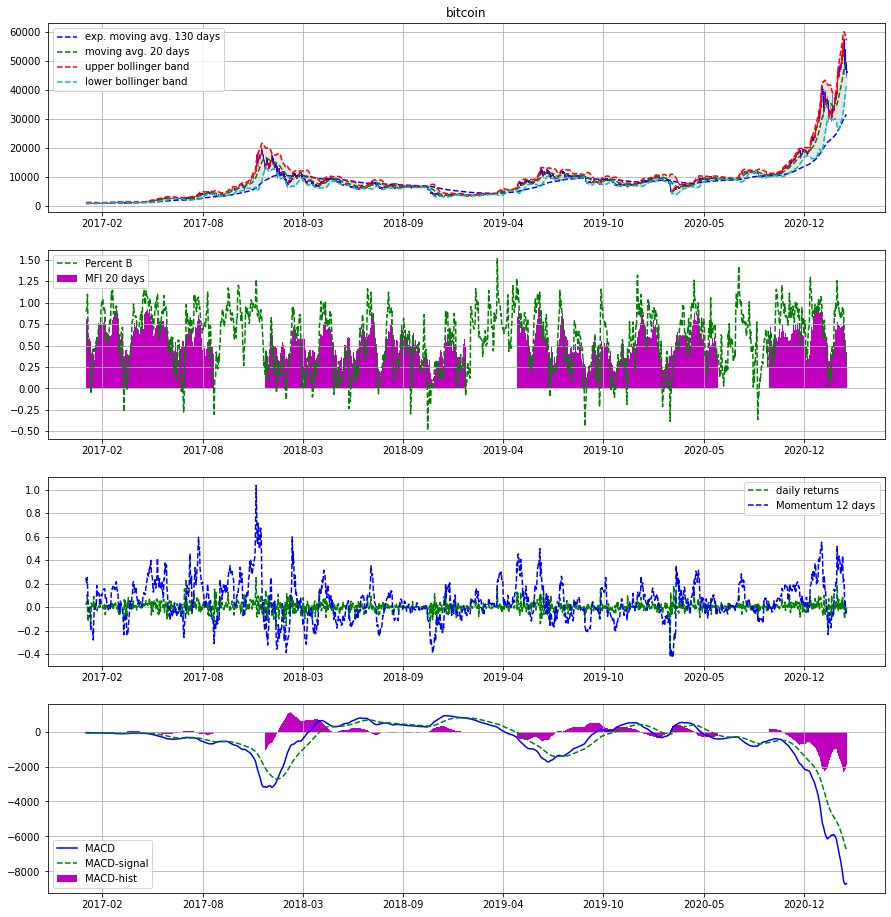

In [5]:
# draw plots
plt.figure(figsize=(15, 16))

# first panel
# draw ohlc and bollinger band
p1 = plt.subplot(4, 1, 1)
plt.title("bitcoin")
candlestick_ohlc(p1, ohlc.values, width=.8, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(ema130.number, ema130.EMA130, 'b--', label='exp. moving avg. 130 days')
plt.plot(bollinger.number, bollinger.Center, 'g--', label='moving avg. 20 days')
plt.plot(bollinger.number, bollinger.Upper, 'r--', label='upper bollinger band')
plt.plot(bollinger.number, bollinger.Lower, 'c--', label='lower bollinger band')
plt.fill_between(bollinger.number, bollinger.Upper, bollinger.Lower, color='0.9')
plt.grid(True)
plt.legend(loc='best')

# second panel
# PB and MFI
p2 = plt.subplot(4, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(bollinger.number, bollinger.PercentB, 'g--', label='Percent B')
plt.bar(mfi.number, mfi.MFI, color='m', label='MFI 20 days')
plt.grid(True)
plt.legend(loc='best')

# third panel
# daily returns and momentum
p3 = plt.subplot(4, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df.rtn, 'g--', label='daily returns')
plt.plot(momentum.number, momentum.Momentum, 'b--', label='Momentum 12 days')
plt.grid(True)
plt.legend(loc='best')

# fourth panel
# macd-hist
p4 = plt.subplot(4, 1, 4)
p4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(macd.number, macd.MACDHist, color='m', label='MACD-hist')
plt.plot(macd.number, macd.MACD, color='b', label='MACD')
plt.plot(macd.number, macd.signal, 'g--', label='MACD-signal')
plt.grid(True)
plt.legend(loc='best')

plt.show()


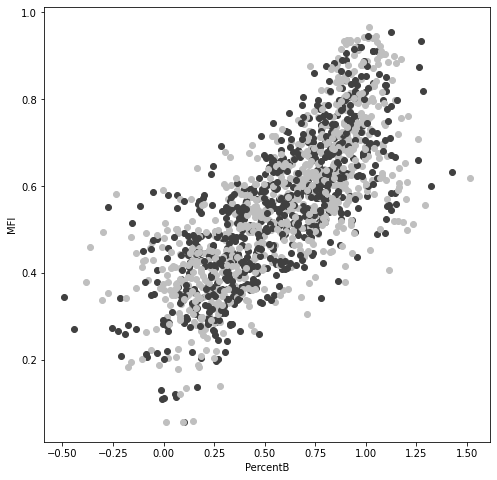

In [6]:
# PB vs MFI
temp = ohlc[['Open', 'Close']]
temp = temp.join(bollinger[['PercentB']])
temp = temp.join(mfi[['MFI']])

plt.figure(figsize=(8, 8))
for idx in temp.index:
    if temp.shift(-1).loc[idx, 'Close'] > temp.shift(-1).loc[idx, 'Open']:
        plt.scatter(temp.loc[idx, 'PercentB'], temp.loc[idx, 'MFI'], color='0.75')
    else:
        plt.scatter(temp.loc[idx, 'PercentB'], temp.loc[idx, 'MFI'], color='0.25')
plt.xlabel("PercentB")
plt.ylabel("MFI")
plt.show()

<ipython-input-7-4b3527a52f4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MACDHist'] = (macd['MACDHist'] - macd['MACDHist'].mean())/macd['MACDHist'].std()


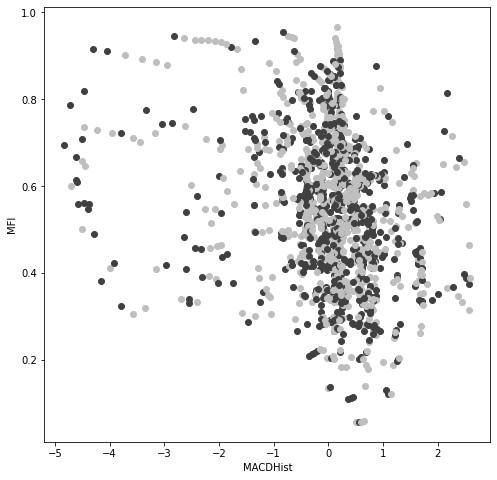

In [7]:
# MACDHist vs MFI
temp = ohlc[['Open', 'Close']]
# normalize MACDHist
temp['MACDHist'] = (macd['MACDHist'] - macd['MACDHist'].mean())/macd['MACDHist'].std()
temp = temp.join(mfi[['MFI']])
temp.head()

plt.figure(figsize=(8, 8))
for idx in temp.index:
    if temp.shift(-1).loc[idx, 'Close'] > temp.shift(-1).loc[idx, 'Open']:
        plt.scatter(temp.loc[idx, 'MACDHist'], temp.loc[idx, 'MFI'], color='0.75')
    else:
        plt.scatter(temp.loc[idx, 'MACDHist'], temp.loc[idx, 'MFI'], color='0.25')
plt.xlabel("MACDHist")
plt.ylabel("MFI")
plt.show()

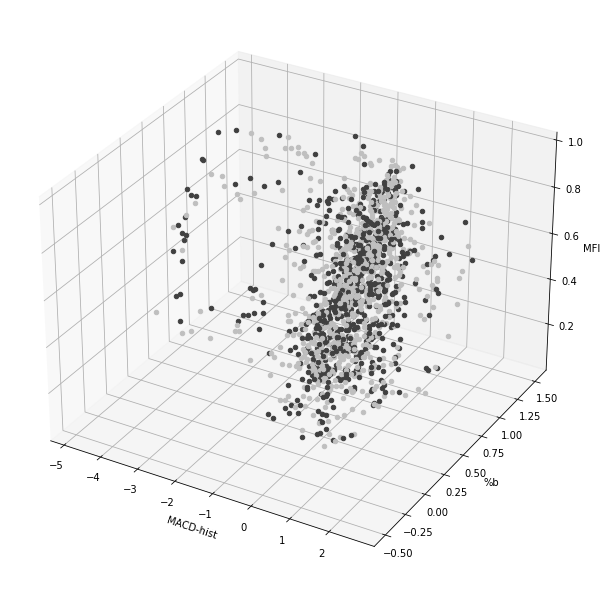

In [8]:
# MACD-hist vs PercentB vs MFI
temp = ohlc[['Open', 'Close']].copy()
temp['MACDHist'] = (macd['MACDHist'] - macd['MACDHist'].mean())/macd['MACDHist'].std()
temp = temp.join(bollinger[['PercentB']])
temp = temp.join(mfi[['MFI']])

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

for idx in temp.index:
    if temp.shift(-1).loc[idx, 'Close'] > temp.shift(-1).loc[idx, 'Open']:
        ax.scatter(temp.loc[idx, 'MACDHist'], temp.loc[idx, 'PercentB'], temp.loc[idx, 'MFI'], color='0.75')
    else:
        ax.scatter(temp.loc[idx, 'MACDHist'], temp.loc[idx, 'PercentB'], temp.loc[idx, 'MFI'], color='0.25')
ax.set_xlabel("MACD-hist")
ax.set_ylabel("%b")
ax.set_zlabel("MFI")
plt.show()